# Bioscreen data analysis
In this notebook, I use python to read my bioscreen excel data to calculate growth rate.
## Step 1: load python packages

In [1]:
import pandas as pd
import scipy as scp
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

C:\Users\mmakt\AppData\Local\Temp\ipykernel_10392\509084282.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Function definitions
These functions are the core of the data analysis in this notebook.

In [2]:
def detection_time(t_exp, gr_exp, growth_increase = 0.05):
    """
    t_exp is an array of time
    gr_exp is an array of growth rate
    growth increase is a constant with the default value of 0.05
    
    both t and gr must be of the same length
    returns 
    detection time: returns the detected time if growth is observed, otherwise, returns -1
    growth detection: True means growth is detected
    """
    # Savgol filter:
    gr_filtered = savgol_filter(gr_exp, 40, 3)
    # filter the data for negative and zero values
    gr = gr_filtered[gr_filtered>0]
    t = t_exp[gr_filtered>0]
    # find the minimum value of gr
    n_search = np.maximum(int(0.1*len(gr)), 1)
    min_val = gr[0:n_search].min()
    idx_min = gr[0:n_search].argmin()
    gr_d = min_val+growth_increase
    idx = np.where(gr>=gr_d)
    idx_t = np.where(idx[0]>idx_min)
    idx_detection_t = idx[0][idx_t[0][0]] if len(idx_t[0])>0 else idx_min
    growth_detection = idx_detection_t>idx_min 
    # interpolation for finding detection time
    if growth_detection:    
        m = (gr[idx_detection_t] - gr[idx_detection_t-1])/(t[idx_detection_t]-t[idx_detection_t-1])
        detection_t = t[idx_detection_t] - (gr[idx_detection_t]-gr_d)/m
    else:
        detection_t = -1
    return detection_t, growth_detection

def specific_growth_rate(t, repetition, n_strain=16, n_test=6, N0_plan=[1e5, 1e4, 1e3, 1e2, 1e1]):
    # n = len(repetition.columns)
    n = n_strain*n_test
    detection_t = np.zeros(n)
    growth_detected = np.zeros(n)
    for i in range(n):
        detection_t[i], growth_detected[i] = detection_time(t.values, repetition.values[:,i])

    # assign detection time to each experiment
    lnN0 = np.log(N0_plan)
    DT = np.zeros((n_strain, n_test-1))
    for i in range(n_strain):
        for j in range(1,n_test):
            DT[i, j-1] = detection_t[i*n_test+j]
    return DT, lnN0

def visualize_growth_curve(t_exp, repetition, strain_index, n_strain=16, n_test=6, l=['blank', '10^5', '10^4', '10^3', '10^2', '10^1']):
    # filter data in a loop
    for i in range(0, n_test):
        t = t_exp.values
        g = repetition.values[:, strain_index*n_test+i]
        t = t[g>0]
        g = g[g>0]
        plt.plot(t, g, label='$'+l[i]+'$')
    plt.xlabel('time [h]')
    plt.ylabel('Absorbance (540 nm)')
    plt.legend()


def visualize_specific_growth(DT, lnN0, strain_no, min_valid_point=3, ps='o', ls='-', points=[1,2,3,4,5]):
    pf = np.array(points)-1 # selected points by the user
    t = DT[strain_no, :]
    m, r, p, se, b = fit_specific_growth_rate(t, lnN0, min_valid_point=min_valid_point, points=points)
    plt.plot(t[pf][t[pf]!=-1], lnN0[pf][t[pf]!=-1], ps)
    if len(t[t!=-1])>=min_valid_point:
        plt.plot(t[pf][t[pf]!=-1], m*t[pf][t[pf]!=-1]+b, ls)
    plt.xlabel('Detection time [h]')
    plt.ylabel('ln(N0)')

def fit_specific_growth_rate(DT, lnN0, min_valid_point=3, points=[1,2,3,4,5]):
    """
    fits a line to the ln N0 vs detected growth time curve
    It also reports goodness of fit, p-value of a t test, and standard error of the slope
    """
    pf = np.array(points)-1 # selected points by the user
    DT_filtered = DT[pf][DT[pf]!=-1]
    if len(DT_filtered)<min_valid_point:
        slope = 0
        r = 0
        p = 0
        se = 0
        intercept = 0
    else:
        slope, intercept, r, p, se = linregress(DT_filtered, lnN0[pf][DT[pf]!=-1])
    return slope, np.square(r), p, se, intercept
    

## step 2: read excel files

In [14]:
plate = pd.read_excel('pH_aw_Exp1_psy 15C_301122_161222.xls', header = 2)
plate.head()

WARNING *** file size (2811596) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,Time,Blank,1,2,3,4,5,6,7,8,...,191,192,193,194,195,196,197,198,199,200
0,0.018714,0,0.137,0.144,0.145,0.135,0.137,0.143,0.139,0.146,...,0.167,0.190,0.186,0.174,0.184,0.178,0.284,0.277,0.271,0.269
1,0.501740,0,0.139,0.147,0.144,0.133,0.134,0.143,0.137,0.145,...,0.166,0.185,0.180,0.168,0.178,0.173,0.084,0.084,0.083,0.085
2,1.001738,0,0.140,0.147,0.142,0.132,0.133,0.141,0.136,0.144,...,0.169,0.187,0.181,0.170,0.179,0.176,0.085,0.085,0.084,0.086
3,1.501731,0,0.134,0.139,0.135,0.126,0.126,0.133,0.128,0.138,...,0.160,0.179,0.173,0.161,0.171,0.168,0.084,0.084,0.083,0.085
4,2.001732,0,0.143,0.147,0.142,0.132,0.133,0.140,0.136,0.145,...,0.169,0.185,0.179,0.168,0.176,0.175,0.083,0.082,0.082,0.083


# Experimental procedure
For each strain, 6 experiments are performed in different dilutions (10^5, 10^4, 10^3, 10^2, 10^1). The first column of data is blank followed by the above 5 dilutions. The experiments are indexed below:

In [15]:
# 16 x 6 column of data
n_strain = 16
n_test = 6
strain_label = ['pH 4.8', 'pH 5.0', 'pH 5.25', 'pH 5.5', 'pH 6.0', 'pH 6.4', 'pH 6.8', 'pH 7.5', '1.5% NaCl', '3% NaCl', '4% NaCl', '5% NaCl', '6% NaCl', '6.75% NaCl', '7.25% NaCl', '8% NaCl']
exp_index = [1, 2, 3, 4, 5, 6]
N0_plan = [1e5, 1e4, 1e3, 1e2, 1e1]
N0 = np.zeros((16, 5))

## Step 2a: separate repetitions from main data

In [16]:
plate_time = plate.Time
plate_rep_1 = plate[plate.columns[2:102]]
plate_rep_2 = plate[plate.columns[102:]]
print(len(plate_rep_1.columns))
plate_rep_1.head()

100


,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,0.137,0.144,0.145,0.135,0.137,0.143,0.139,0.146,0.147,0.156,...,0.166,0.183,0.175,0.166,0.167,0.167,0.291,0.278,0.270,0.202
1,0.139,0.147,0.144,0.133,0.134,0.143,0.137,0.145,0.145,0.149,...,0.161,0.178,0.170,0.162,0.163,0.164,0.087,0.085,0.083,0.085
2,0.140,0.147,0.142,0.132,0.133,0.141,0.136,0.144,0.144,0.145,...,0.162,0.179,0.171,0.162,0.164,0.166,0.086,0.085,0.083,0.086
3,0.134,0.139,0.135,0.126,0.126,0.133,0.128,0.138,0.136,0.137,...,0.150,0.171,0.164,0.154,0.157,0.158,0.086,0.085,0.083,0.085
4,0.143,0.147,0.142,0.132,0.133,0.140,0.136,0.145,0.144,0.144,...,0.160,0.177,0.170,0.160,0.163,0.165,0.085,0.084,0.082,0.085


## Step 3: detection time

In [17]:
# alternative method
dt1, lng1 = specific_growth_rate(plate_time, plate_rep_1) # repetition 1
dt2, lng2 = specific_growth_rate(plate_time, plate_rep_2) # repetition 2
# dt2
# dt2

## Step 4: fit a model to data

In [18]:
# fit a line
strain_no = 15
mu_max1 = np.zeros(n_strain)
r1 = np.zeros(n_strain)
p1 = np.zeros(n_strain)
se1 = np.zeros(n_strain)

mu_max2 = np.zeros(n_strain)
r2 = np.zeros(n_strain)
p2 = np.zeros(n_strain)
se2 = np.zeros(n_strain)

for i in range(n_strain):
    mu_max1[i], r1[i], p1[i], se1[i], b = fit_specific_growth_rate(dt1[i, :], lng1)
    mu_max2[i], r2[i], p2[i], se2[i], b = fit_specific_growth_rate(dt2[i, :], lng2)
mu_max1, mu_max2

(array([ 0.        ,  0.        , -0.07515249, -0.19912018, -0.32109546,
        -0.3854084 , -0.39574944, -0.40443689, -0.3235791 , -0.26071989,
        -0.1420083 , -0.02547578, -0.04188456,  0.        ,  0.        ,
         0.        ]),
 array([ 0.        ,  0.        , -0.0460877 , -0.18413919, -0.3183632 ,
        -0.40214224, -0.4304925 , -0.43883205, -0.31162487, -0.24413222,
        -0.1051677 , -0.03298175,  0.        ,  0.        ,  0.        ,
         0.        ]))

# Plot some of the results

In [19]:
strain_no = 0
# dt1[strain_no, -1] = -1
for strain_no in range(n_strain):
    plt.figure(1)
    visualize_specific_growth(dt1, lng1, strain_no, ps='ob', ls='-b')
    visualize_specific_growth(dt2, lng2, strain_no, ps='^r', ls='--r')
    plt.legend(['rep1', '', 'rep2', ''])
    plt.title(strain_label[strain_no])
    plt.xlabel('DT [h]')
    plt.ylabel('ln N0')
    plt.savefig('detection_time_'+strain_label[strain_no]+'.png', dpi=150, bbox_inches='tight', facecolor='w')
    plt.close('all')

In [20]:
for strain_no in range(n_strain):
    plt.figure(2)
    visualize_growth_curve(plate_time, plate_rep_1, strain_no)
    plt.title(strain_label[strain_no]+' rep1')
    plt.savefig('growth_'+strain_label[strain_no]+'_rep1.png', dpi=150, bbox_inches='tight', facecolor='w')
    plt.figure(3)
    visualize_growth_curve(plate_time, plate_rep_2, strain_no)
    plt.title(strain_label[strain_no]+' rep2')
    plt.savefig('growth_'+strain_label[strain_no]+'_rep2.png',  dpi=150, bbox_inches='tight', facecolor='w')
    plt.close('all')

## Individual plot

(0.0, 100.0, 0.0, 1.5)

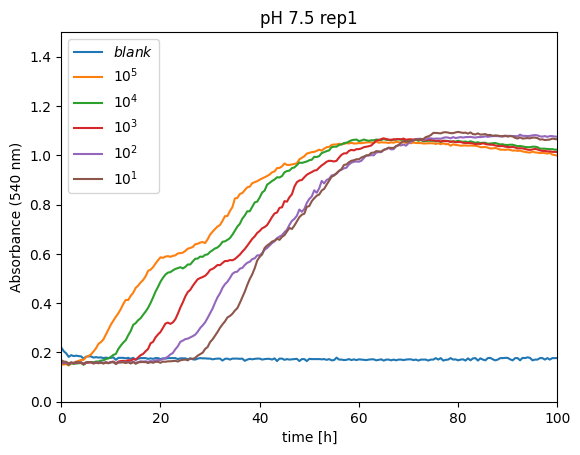

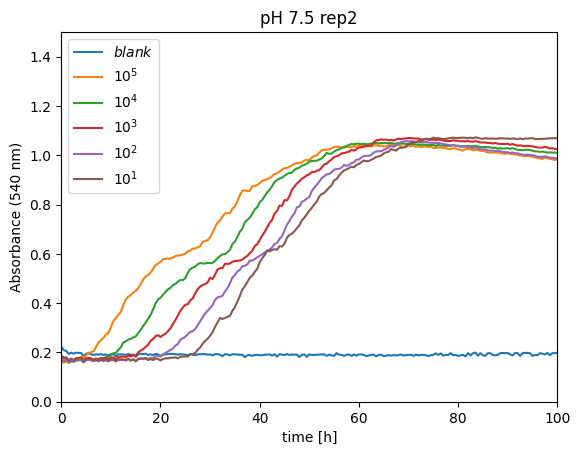

In [25]:
strain_name = 'pH 7.5'
strain_no = strain_label.index(strain_name)
axis_limit = [0, 100, 0, 1.5]

rep_num = 1
plt.figure(4)
visualize_growth_curve(plate_time, plate_rep_1, strain_no)
plt.title(strain_label[strain_no]+' rep'+str(rep_num))
plt.axis(axis_limit)
#plt.savefig('growth_'+strain_label[strain_no]+'_rep'+str(rep_num)+'_cropped.png', dpi=150, bbox_inches='tight', facecolor='w')

rep_num = 2
plt.figure(5)
visualize_growth_curve(plate_time, plate_rep_2, strain_no)
plt.title(strain_label[strain_no]+' rep'+str(rep_num))
plt.axis(axis_limit)
#plt.savefig('growth_'+strain_label[strain_no]+'_rep'+str(rep_num)+'_cropped.png', dpi=150, bbox_inches='tight', facecolor='w')

## Individual fit and visualization
It is now possible to fit the model only to the selected data points:

(-0.40443688828024815,
 0.9946256491706081,
 0.00016748640267331874,
 0.017164189955748678,
 13.59294808291385)

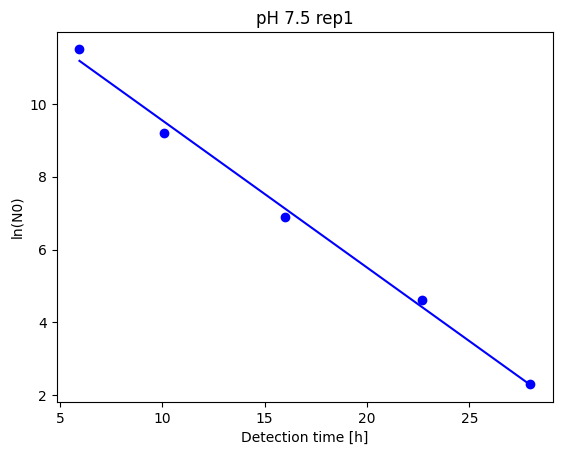

In [27]:
strain_name = 'pH 7.5'
strain_no = strain_label.index(strain_name)
rep_num = 1
if rep_num==1:
    DT = dt1
    lng = lng1
else:
    DT = dt2
    lng = lng2
points=[1,2,3,4,5]
plt.figure(4)
visualize_specific_growth(DT, lng, strain_no, ps='ob', ls='-b', points=points)
plt.title(strain_label[strain_no]+' rep'+str(rep_num))
mu_max, intercept, r, p, se = fit_specific_growth_rate(dt1[strain_no, :], lng1, points=points)
mu_max, intercept, r, p, se

## Step 3: write to excel file


In [28]:
mu = np.abs(np.vstack([mu_max1, mu_max2]))
mean_mu = np.mean(mu, axis=0)
std_mu = np.std(mu, axis =0)
percent_std_mu = std_mu*100/mean_mu

df1 = pd.DataFrame(np.vstack([dt1.T, mu_max1, r1, se1]), columns=strain_label, index=['1e5', '1e4', '1e3', '1e2', '1e1', 'mu_max', 'R_fit', 'Standard error'])
df2 = pd.DataFrame(np.vstack([dt2.T, mu_max2, r2, se2]), columns=strain_label, index=['1e5', '1e4', '1e3', '1e2', '1e1', 'mu_max', 'R_fit', 'Standard error'])
df3 = pd.DataFrame(np.vstack([mu, mean_mu, std_mu, percent_std_mu]), columns=strain_label, index=['mu_max_rep1', 'mu_max_rep2', 'mean', 'std', 'std_percent'])
with pd.ExcelWriter('Growth_Rate_Result.xlsx') as writer:
    df1.to_excel(writer, sheet_name='Repetition 1')
    df2.to_excel(writer, sheet_name='Repetition 2')
    df3.to_excel(writer, sheet_name='mu_max')

C:\Users\mmakt\AppData\Local\Temp\ipykernel_10392\424576037.py:4: RuntimeWarning: invalid value encountered in divide
  percent_std_mu = std_mu*100/mean_mu
